<a href="https://colab.research.google.com/github/shreyasriram4/DL_assignment_2/blob/main/dl_ass2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os
import gzip
import shutil
from google.colab import drive

drive.mount('/content/drive')
zip_file_path = '/content/drive/My Drive/ptb_data.zip'

# Unzipping the file to a folder named 'unzipped_data'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/unzipped_data')

# Check the contents of the unzipped folder
os.listdir('/content/unzipped_data')


input_folder = '/content/unzipped_data/ptb_data'

# Define the paths to text files
train_path = os.path.join(input_folder, 'ptb.train.txt')
test_path = os.path.join(input_folder, 'ptb.test.txt')
val_path = os.path.join(input_folder, 'ptb.valid.txt')

def read_ptb(filename):
    """
    Reads a PTB text file and returns the data as a list of words.
    """
    with open(filename, 'r') as f:
        return f.read().replace('\n', '<eos>').split()

# Read text data
train_text = read_ptb(train_path)
test_text = read_ptb(test_path)
val_text = read_ptb(val_path)

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from collections import defaultdict
import torch

# Function to build vocabulary from training tokens
def build_vocab(tokens):
    vocab = defaultdict(lambda: len(vocab))  # Defaultdict to assign unique indices
    for token in tokens:
        _ = vocab[token]
    return dict(vocab)

# Building the vocabulary from the training tokens
vocab = build_vocab(train_text)

# Function to convert tokens to their respective indices using the vocabulary
def convert_tokens_to_indices(tokens_list, vocab):
    return [vocab[token] for token in tokens_list]

# Converting tokens to indices for train, validation, and test datasets
train_indices = convert_tokens_to_indices(train_text, vocab)
val_indices = convert_tokens_to_indices(val_text, vocab)
test_indices = convert_tokens_to_indices(test_text, vocab)

# Function to create batched data tensors
def generate_batches(data_indices, batch_size):
    total_batches = len(data_indices) // batch_size
    data_tensor = torch.tensor(data_indices[:total_batches * batch_size], dtype=torch.long)
    return data_tensor.view(batch_size, -1)

# Defining batch size and creating batched data tensors for train, validation, and test sets
batch_size = 20
train_data = generate_batches(train_indices, batch_size)
val_data = generate_batches(val_indices, batch_size)
test_data = generate_batches(test_indices, batch_size)

In [3]:
def detach_hidden_state(hidden_state):
    """Detaches hidden states from their computational history."""
    if isinstance(hidden_state, torch.Tensor):
        return hidden_state.detach()
    return tuple(detach_hidden_state(sub_hidden) for sub_hidden in hidden_state)

# Function to generate batches of input and target sequences
def create_batch(data_source, batch_idx, sequence_length):
    # Slice out the input sequence for this batch
    input_seq = [data_source[row_idx, batch_idx * sequence_length:(batch_idx + 1) * sequence_length]
                 for row_idx in range(batch_size)]

    # Slice out the target sequence, shifted by one time step
    target_seq = [data_source[row_idx, batch_idx * sequence_length + 1:(batch_idx + 1) * sequence_length + 1]
                  for row_idx in range(batch_size)]

    # Stack input and target sequences
    input_seq_tensor = torch.stack(input_seq, dim=1)  # Shape: [sequence_length, batch_size]
    target_seq_tensor = torch.stack(target_seq, dim=1)
    return input_seq_tensor, target_seq_tensor

# Training function
def train(model, train_data, loss_function, optimizer, sequence_length):
    model.train()
    accumulated_loss = 0.0
    hidden_state = model.init_hidden(batch_size)

    num_batches = train_data.size(1) // sequence_length
    for batch_index in range(num_batches):
        inputs, targets = create_batch(train_data, batch_index, sequence_length)
        inputs, targets = inputs.to(device), targets.to(device)

        # Detach hidden state from history
        hidden_state = detach_hidden_state(hidden_state)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions, hidden_state = model(inputs, hidden_state)
        loss = loss_function(predictions.view(-1, vocab_size), targets.view(-1))

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.25)
        optimizer.step()

        accumulated_loss += loss.item()

    return accumulated_loss / num_batches

# Evaluation function
def evaluate(model, validation_data, loss_function, sequence_length):
    model.eval()
    accumulated_loss = 0.0
    hidden_state = model.init_hidden(batch_size)

    num_batches = validation_data.size(1) // sequence_length
    with torch.no_grad():
        for batch_index in range(num_batches):
            inputs, targets = create_batch(validation_data, batch_index, sequence_length)
            inputs, targets = inputs.to(device), targets.to(device)

            # Detach hidden state
            hidden_state = detach_hidden_state(hidden_state)

            # Forward pass
            predictions, hidden_state = model(inputs, hidden_state)
            loss = loss_function(predictions.view(-1, vocab_size), targets.view(-1))
            accumulated_loss += loss.item()

    return accumulated_loss / num_batches

Epoch 1 - Train Perplexity: 581.4779, Validation Perplexity: 382.5323, Test Perplexity: 373.0061
Epoch 2 - Train Perplexity: 291.2371, Validation Perplexity: 254.3383, Test Perplexity: 249.3257
Epoch 3 - Train Perplexity: 208.4014, Validation Perplexity: 210.6444, Test Perplexity: 205.8259
Epoch 4 - Train Perplexity: 168.4195, Validation Perplexity: 181.0795, Test Perplexity: 176.5364
Epoch 5 - Train Perplexity: 142.4572, Validation Perplexity: 165.1101, Test Perplexity: 160.1134
Epoch 6 - Train Perplexity: 129.8568, Validation Perplexity: 157.6681, Test Perplexity: 152.8528
Epoch 7 - Train Perplexity: 120.2876, Validation Perplexity: 152.2765, Test Perplexity: 147.9151
Epoch 8 - Train Perplexity: 112.4305, Validation Perplexity: 148.3014, Test Perplexity: 144.2838
Epoch 9 - Train Perplexity: 104.1143, Validation Perplexity: 143.5345, Test Perplexity: 139.8254
Epoch 10 - Train Perplexity: 99.6934, Validation Perplexity: 141.7183, Test Perplexity: 138.1372
Epoch 11 - Train Perplexity: 9

<ipython-input-4-4e9cabb34ca7>:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
<ipython-input-4-4e9cabb34ca7>:105: Futu

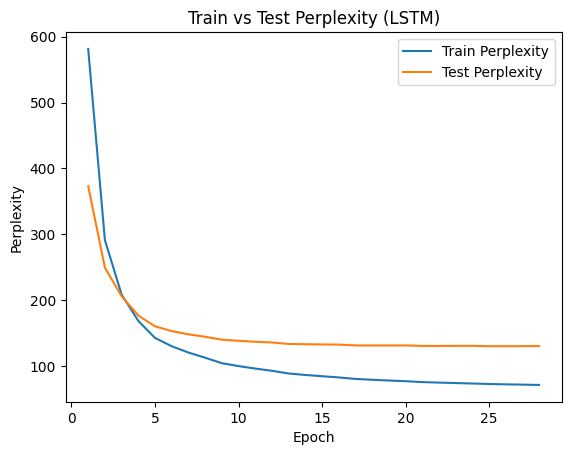

In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2, initrange=0.1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer with uniform initialization
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.weight.data.uniform_(-initrange, initrange)

        # LSTM layers
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=False)

        # Final output layer
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden and cell states with zeros
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = len(vocab)
embed_size = 200
hidden_size = 200
num_layers = 2
seq_length = 20

model = LSTMModel(vocab_size, embed_size, hidden_size, num_layers).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer setup
optimizer = optim.SGD(model.parameters(), lr=3.0, momentum=0.0)  # SGD with lr=3.0
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 / (1.5 ** (epoch // 4)))

# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

class PerplexityTracker:
    def __init__(self):
        self.train_perplexities = []
        self.val_perplexities = []
        self.test_perplexities = []

    def calculate_and_store(self, epoch, model, train_loss, val_data, test_data):
        # Store train perplexity
        train_perplexity = np.exp(train_loss)
        self.train_perplexities.append(train_perplexity)

        # Evaluate validation loss and store validation perplexity
        val_loss = evaluate(model, val_data, criterion, seq_length)
        val_perplexity = np.exp(val_loss)
        self.val_perplexities.append(val_perplexity)

        # Evaluate test loss and store test perplexity
        test_loss = evaluate(model, test_data, criterion, seq_length)
        test_perplexity = np.exp(test_loss)
        self.test_perplexities.append(test_perplexity)

        # Updated print statement with validation loss
        print(f"Epoch {epoch} - Train Perplexity: {train_perplexity:.4f}, "
              f"Validation Perplexity: {val_perplexity:.4f}, Test Perplexity: {test_perplexity:.4f}")

        return val_loss  # Return val_loss for early stopping

tracker = PerplexityTracker()

for epoch in range(1, 30):  # Training for 30 epochs
    train_loss = train(model, train_data, criterion, optimizer, seq_length)
    val_loss = tracker.calculate_and_store(epoch, model, train_loss, val_data, test_data)

    # Update learning rate using the scheduler
    scheduler.step()

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch}")
            model.load_state_dict(torch.load('best_model.pt'))
            break

# Load and save the final model weights
model.load_state_dict(torch.load('best_model.pt'))
torch.save(model.state_dict(), 'final_model_weights.pt')

# Plotting Train vs Validation vs Test Perplexity over epochs
plt.plot(range(1, len(tracker.train_perplexities) + 1), tracker.train_perplexities, label='Train Perplexity')
#plt.plot(range(1, len(tracker.val_perplexities) + 1), tracker.val_perplexities, label='Validation Perplexity')
plt.plot(range(1, len(tracker.test_perplexities) + 1), tracker.test_perplexities, label='Test Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Train vs Test Perplexity (LSTM)')
plt.legend()
plt.show()

Epoch 1 - Train Perplexity: 601.1346, Validation Perplexity: 402.2512, Test Perplexity: 391.3057
Epoch 2 - Train Perplexity: 317.4722, Validation Perplexity: 258.3286, Test Perplexity: 252.4911
Epoch 3 - Train Perplexity: 234.6608, Validation Perplexity: 212.9380, Test Perplexity: 207.2086
Epoch 4 - Train Perplexity: 196.4679, Validation Perplexity: 188.2153, Test Perplexity: 182.2011
Epoch 5 - Train Perplexity: 172.5190, Validation Perplexity: 169.7247, Test Perplexity: 164.8066
Epoch 6 - Train Perplexity: 156.0967, Validation Perplexity: 158.3847, Test Perplexity: 153.7346
Epoch 7 - Train Perplexity: 143.8914, Validation Perplexity: 149.7712, Test Perplexity: 145.6920
Epoch 8 - Train Perplexity: 134.2618, Validation Perplexity: 142.8149, Test Perplexity: 139.0028
Epoch 9 - Train Perplexity: 124.5483, Validation Perplexity: 136.7112, Test Perplexity: 132.5412
Epoch 10 - Train Perplexity: 119.3860, Validation Perplexity: 133.4296, Test Perplexity: 129.3373
Epoch 11 - Train Perplexity: 

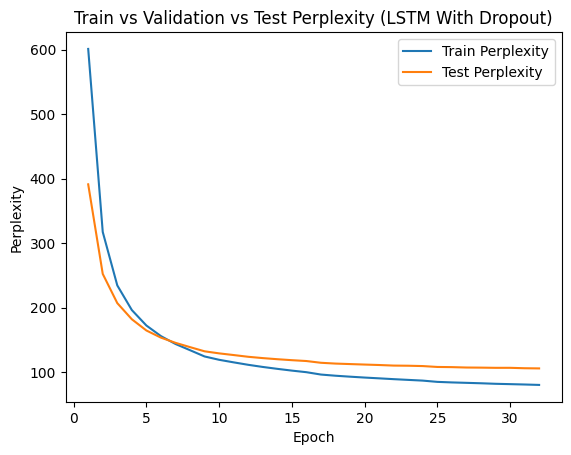

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2, initrange=0.1, dropout=0.25):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_prob = dropout

        # Embedding layer with uniform initialization
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.weight.data.uniform_(-initrange, initrange)

        # LSTM layers with dropout
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=False, dropout=dropout)

        # Dropout layers
        self.dropout = nn.Dropout(dropout)

        # Final output layer
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.dropout(self.embedding(x))  # Apply dropout after embedding
        out, hidden = self.lstm(x, hidden)   # LSTM layers already have dropout included
        out = self.dropout(out)              # Apply dropout to LSTM outputs
        out = self.fc(out)                   # Final output layer
        return out, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden and cell states with zeros
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = len(vocab)
embed_size = 200
hidden_size = 200
num_layers = 2
seq_length = 20

model = LSTMModel(vocab_size, embed_size, hidden_size, num_layers).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer setup
optimizer = optim.SGD(model.parameters(), lr=3.0, momentum=0.0)  # SGD with lr=3.0
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 / (1.5 ** (epoch // 8)))

# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0
early_stop_val_threshold = 4.7

tracker = PerplexityTracker()

for epoch in range(1, 80):  # Training for up to 50 epochs
    train_loss = train(model, train_data, criterion, optimizer, seq_length)
    val_loss = tracker.calculate_and_store(epoch, model, train_loss, val_data, test_data)

    # Update learning rate using the scheduler
    scheduler.step()

    # Early stopping check when val_loss <= 4.7
    if val_loss <= early_stop_val_threshold:
        print(f"Stopping early as validation loss reached {val_loss:.4f} at epoch {epoch}")
        torch.save(model.state_dict(), 'best_model.pt')
        break

    # Standard early stopping check based on the best_val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping due to patience at epoch {epoch}")
            model.load_state_dict(torch.load('best_model.pt'))
            break

# Load and save the final model weights
torch.save(model.state_dict(), 'final_model_weights_lstm_dropout.pt')

# Plotting Train vs Validation vs Test Perplexity over epochs
plt.plot(range(1, len(tracker.train_perplexities) + 1), tracker.train_perplexities, label='Train Perplexity')
#plt.plot(range(1, len(tracker.val_perplexities) + 1), tracker.val_perplexities, label='Validation Perplexity')
plt.plot(range(1, len(tracker.test_perplexities) + 1), tracker.test_perplexities, label='Test Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Train vs Validation vs Test Perplexity (LSTM With Dropout)')
plt.legend()
plt.show()

Epoch 1 - Train Perplexity: 448.5658, Validation Perplexity: 279.4993, Test Perplexity: 274.9058
Epoch 2 - Train Perplexity: 213.2593, Validation Perplexity: 199.9212, Test Perplexity: 195.2697
Epoch 3 - Train Perplexity: 158.9279, Validation Perplexity: 168.9890, Test Perplexity: 165.5898
Epoch 4 - Train Perplexity: 131.8732, Validation Perplexity: 153.7279, Test Perplexity: 151.0715
Epoch 5 - Train Perplexity: 111.8598, Validation Perplexity: 142.5435, Test Perplexity: 139.7098
Epoch 6 - Train Perplexity: 102.3605, Validation Perplexity: 137.9124, Test Perplexity: 135.1358
Epoch 7 - Train Perplexity: 94.8285, Validation Perplexity: 134.6682, Test Perplexity: 131.9111
Epoch 8 - Train Perplexity: 88.4750, Validation Perplexity: 132.4458, Test Perplexity: 129.7260
Stopping early as validation loss reached 4.8862 at epoch 8


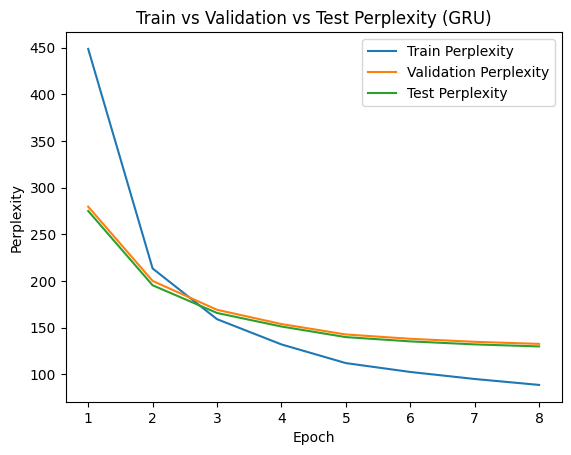

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2, initrange=0.1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer with uniform initialization
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.weight.data.uniform_(-initrange, initrange)

        # GRU layers without dropout
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=False)

        # Final output layer
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)  # No dropout applied
        out, hidden = self.gru(x, hidden)  # GRU layers without dropout
        out = self.fc(out)                 # Final output layer
        return out, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros for GRU
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = len(vocab)
embed_size = 200
hidden_size = 200
num_layers = 2
seq_length = 20  # Same sequence length

model = GRUModel(vocab_size, embed_size, hidden_size, num_layers).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer setup
optimizer = optim.SGD(model.parameters(), lr=3.0, momentum=0.0)  # SGD with lr=3.0
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 / (1.5 ** (epoch // 4)))

# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0
early_stop_val_threshold = 4.9

tracker = PerplexityTracker()

for epoch in range(1, 50):  # Training for up to 50 epochs
    train_loss = train(model, train_data, criterion, optimizer, seq_length)
    val_loss = tracker.calculate_and_store(epoch, model, train_loss, val_data, test_data)

    # Update learning rate using the scheduler
    scheduler.step()

    # Early stopping check when val_loss <= 4.9
    if val_loss <= early_stop_val_threshold:
        print(f"Stopping early as validation loss reached {val_loss:.4f} at epoch {epoch}")
        torch.save(model.state_dict(), 'best_gru_model.pt')
        break

    # Standard early stopping check based on the best_val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_gru_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping due to patience at epoch {epoch}")
            model.load_state_dict(torch.load('best_gru_model.pt'))
            break

# Load and save the final model weights
model.load_state_dict(torch.load('best_gru_model.pt'))
torch.save(model.state_dict(), 'final_gru_model_weights.pt')

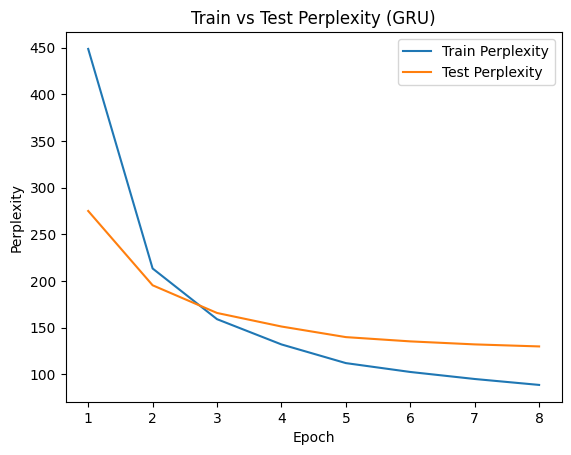

In [ ]:
plt.plot(range(1, len(tracker.train_perplexities) + 1), tracker.train_perplexities, label='Train Perplexity')
plt.plot(range(1, len(tracker.test_perplexities) + 1), tracker.test_perplexities, label='Test Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Train vs Test Perplexity (GRU)')
plt.legend()
plt.show()

Epoch 1 - Train Perplexity: 428.0479, Validation Perplexity: 258.5256, Test Perplexity: 253.2505
Epoch 2 - Train Perplexity: 222.4649, Validation Perplexity: 192.9950, Test Perplexity: 188.2866
Epoch 3 - Train Perplexity: 175.1277, Validation Perplexity: 166.1850, Test Perplexity: 162.6917
Epoch 4 - Train Perplexity: 150.3766, Validation Perplexity: 151.1545, Test Perplexity: 148.2866
Epoch 5 - Train Perplexity: 134.6468, Validation Perplexity: 142.0427, Test Perplexity: 139.5912
Epoch 6 - Train Perplexity: 123.0446, Validation Perplexity: 134.8933, Test Perplexity: 132.3153
Epoch 7 - Train Perplexity: 114.5745, Validation Perplexity: 130.6036, Test Perplexity: 127.9885
Epoch 8 - Train Perplexity: 107.5677, Validation Perplexity: 127.2610, Test Perplexity: 124.6513
Epoch 9 - Train Perplexity: 98.1940, Validation Perplexity: 121.2226, Test Perplexity: 118.2385
Epoch 10 - Train Perplexity: 94.3816, Validation Perplexity: 119.7640, Test Perplexity: 116.9507
Epoch 11 - Train Perplexity: 91

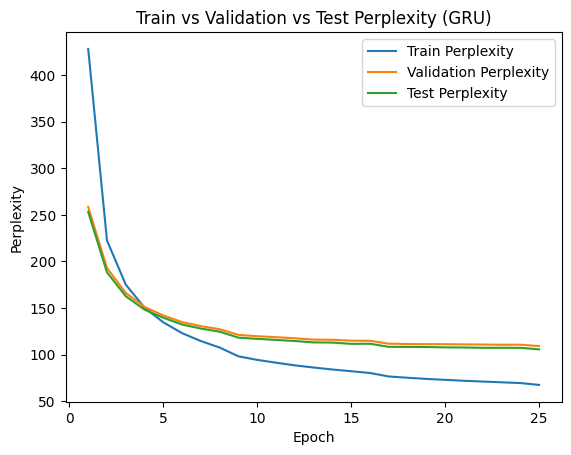

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2, initrange=0.1, dropout=0.25):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_prob = dropout

        # Embedding layer with uniform initialization
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.weight.data.uniform_(-initrange, initrange)

        # GRU layers with dropout applied between layers
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=False, dropout=dropout)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Final output layer
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.dropout(self.embedding(x))  # Apply dropout after embedding
        out, hidden = self.gru(x, hidden)    # GRU layers with dropout between layers
        out = self.dropout(out)              # Apply dropout to GRU outputs
        out = self.fc(out)                   # Final output layer
        return out, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros for GRU
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = len(vocab)
embed_size = 200
hidden_size = 200
num_layers = 2
seq_length = 20  # Same sequence length

model = GRUModel(vocab_size, embed_size, hidden_size, num_layers, dropout=0.25).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer setup
optimizer = optim.SGD(model.parameters(), lr=4.0, momentum=0.0)  # SGD with lr=3.0
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 / (1.5 ** (epoch // 8)))

# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0
early_stop_val_threshold = 4.7

tracker = PerplexityTracker()

for epoch in range(1, 100):  # Training for up to 50 epochs
    train_loss = train(model, train_data, criterion, optimizer, seq_length)
    val_loss = tracker.calculate_and_store(epoch, model, train_loss, val_data, test_data)

    # Update learning rate using the scheduler
    scheduler.step()

    # Early stopping check when val_loss <= 4.7
    if val_loss <= early_stop_val_threshold:
        print(f"Stopping early as validation loss reached {val_loss:.4f} at epoch {epoch}")
        torch.save(model.state_dict(), 'best_gru_model.pt')
        break

    # Standard early stopping check based on the best_val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_gru_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping due to patience at epoch {epoch}")
            model.load_state_dict(torch.load('best_gru_model.pt'))
            break

# Load and save the final model weights
model.load_state_dict(torch.load('best_gru_model.pt'))
torch.save(model.state_dict(), 'final_gru_model_weights.pt')

# Plotting Train vs Validation vs Test Perplexity over epochs
plt.plot(range(1, len(tracker.train_perplexities) + 1), tracker.train_perplexities, label='Train Perplexity')
plt.plot(range(1, len(tracker.val_perplexities) + 1), tracker.val_perplexities, label='Validation Perplexity')
plt.plot(range(1, len(tracker.test_perplexities) + 1), tracker.test_perplexities, label='Test Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Train vs Validation vs Test Perplexity (GRU)')
plt.legend()
plt.show()

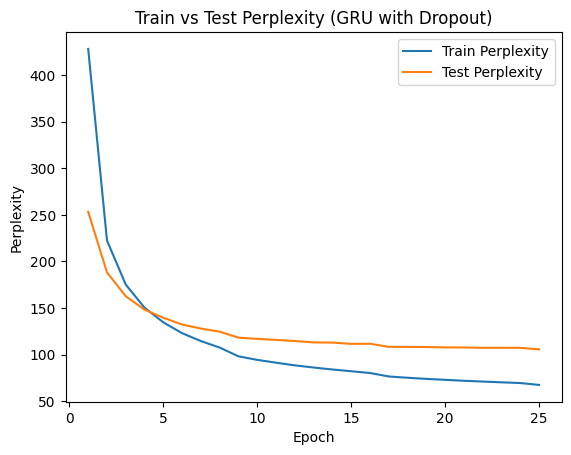

In [ ]:
# Plotting Train vs Validation vs Test Perplexity over epochs
plt.plot(range(1, len(tracker.train_perplexities) + 1), tracker.train_perplexities, label='Train Perplexity')
plt.plot(range(1, len(tracker.test_perplexities) + 1), tracker.test_perplexities, label='Test Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Train vs Test Perplexity (GRU with Dropout)')
plt.legend()
plt.show()